In [1]:
# Sagar Sahu
# IBM Quantum Challenge 2024- Lab 2

!pip install qiskit[visualization]==1.0.2
!pip install qiskit_ibm_runtime
!pip install qiskit_aer
!pip install qiskit-transpiler-service
!pip install graphviz

from qiskit.circuit.random import random_circuit
from qiskit.circuit.library import XGate, YGate
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeOsaka
from qiskit.transpiler import InstructionProperties, PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins
from qiskit.transpiler.timing_constraints import TimingConstraints
from qiskit.transpiler.passes.scheduling import ASAPScheduleAnalysis,PadDynamicalDecoupling
from qiskit.visualization.timeline import draw, IQXStandard
from qiskit.transpiler import StagedPassManager
from qiskit.visualization import plot_circuit_layout
import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.5 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=1fbc0d185e0f7818d5b5eb2456aac1faec6aae269219fe14a241785f3dbd7432
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 12.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done

In [2]:
import numpy as np
from qiskit import transpile, QuantumCircuit

# Cost function to calculate the fidelity of a circuit
def transpile_scoring(circ, layout, backend):
    fid = 1
    touched = set()
    dt = backend.dt
    num_qubits = backend.num_qubits

    error=0
    
    t1s = [backend.qubit_properties(qq).t1 for qq in range(num_qubits)]
    t2s = [backend.qubit_properties(qq).t2 for qq in range(num_qubits)]

    
    for item in circ._data:
        for gate in backend.operation_names:
            if item[0].name == gate:
                if (item[0].name == 'cz') or (item[0].name == 'ecr'):
                    q0 = circ.find_bit(item[1][0]).index
                    q1 = circ.find_bit(item[1][1]).index
                    fid *= 1 - backend.target[item[0].name][(q0, q1)].error
                    touched.add(q0)
                    touched.add(q1)
                elif item[0].name == 'measure':
                    q0 = circ.find_bit(item[1][0]).index
                    fid *= 1 - backend.target[item[0].name][(q0, )].error
                    touched.add(q0)
    
                elif item[0].name == 'delay':
                    q0 = circ.find_bit(item[1][0]).index
                    # Ignore delays that occur before gates
                    # This assumes you are in ground state and errors
                    # do not occur.
                    if q0 in touched:
                        time = item[0].duration * dt
                        fid *= 1-qubit_error(time, t1s[q0], t2s[q0])
                else:
                    q0 = circ.find_bit(item[1][0]).index
                    fid *= 1 - backend.target[item[0].name][(q0, )].error
                    touched.add(q0)
    return fid

def qubit_error(time, t1, t2):
    """Compute the approx. idle error from T1 and T2
    Parameters:
        time (float): Delay time in sec
        t1 (float): T1 time in sec
        t2 (float): T2 time in sec
    Returns:
        float: Idle error
    """
    t2 = min(t1, t2)
    rate1 = 1/t1
    rate2 = 1/t2
    p_reset = 1-np.exp(-time*rate1)
    p_z = (1-p_reset)*(1-np.exp(-time*(rate2-rate1)))/2
    return p_z + p_reset

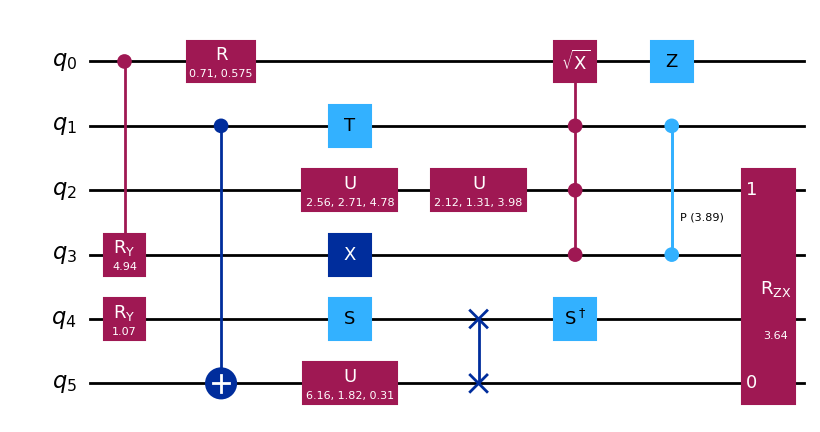

In [3]:
# Preset pass manager stages for transpilation:
# 1. init- this stage is used to translate any gates that operate on more than two qubits, into gates that only operate on one or two qubits
# 2. routing- This stage inserts the appropriate number of SWAP gates in order to execute the circuits using the selected layout
# 3. layout- This stage executes a sequence of gates, a one-to-one mapping from the "virtual" qubits to the "physical" qubits in an actual quantum device
# 4. translation- This stage translates (or unrolls) the gates specified in a circuit to the native basis gates of a specified backend
# 5. optimization- this stage centers around reducing the number of circuit operations and the depth of circuits with several optimization options
# 6. scheduling- this pass can be thought of as explicitly inserting hardware-aware operations like delay instructions to account for the idle time between gate executions

# generate_preset_pass_manager takes 1 arg, optim. level which is an int either 0, 1, 2, 3

# Scoring function that maeasures perfoemance of the transpiled circuit
# receives the transpiled circuit, its final layout, and its target backend as inputs, returning a score (closer to 0 is better)

def scoring (qc, backend):
    layout = qc._layout
    fidelity = transpile_scoring(qc, layout, backend)
    return 1 - fidelity

seed = 10000
num_qubits = 6
depth = 4
qc = random_circuit(num_qubits,depth,measure=False, seed=seed)
qc.draw('mpl')

In [4]:
# 133 qubit backend
backend = FakeTorino()

circuit_depths = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}
gate_counts = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}

scores = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}

# Opt level 0- device characterization experiments, only maps input circuit to target backend
# Make a pass manager with our desired optimization level and backend
pm_level0 = generate_preset_pass_manager(backend=backend, optimization_level=0, seed_transpiler=seed)

backend_converter.convert_to_target:INFO:2024-07-08 15:34:38,945: Gate calibration for instruction measure on qubits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132) is found in the PulseDefaults payload. However, this entry is not defined in the gate mapping of Target. This calibration is ignored.
backend_converter.convert_to_target:INFO:2024-07-08 15:34:38,947: Gate calibration for instruction u1 on qubits (0,) is found in the PulseDefaults payload. However, this entry is not defined in

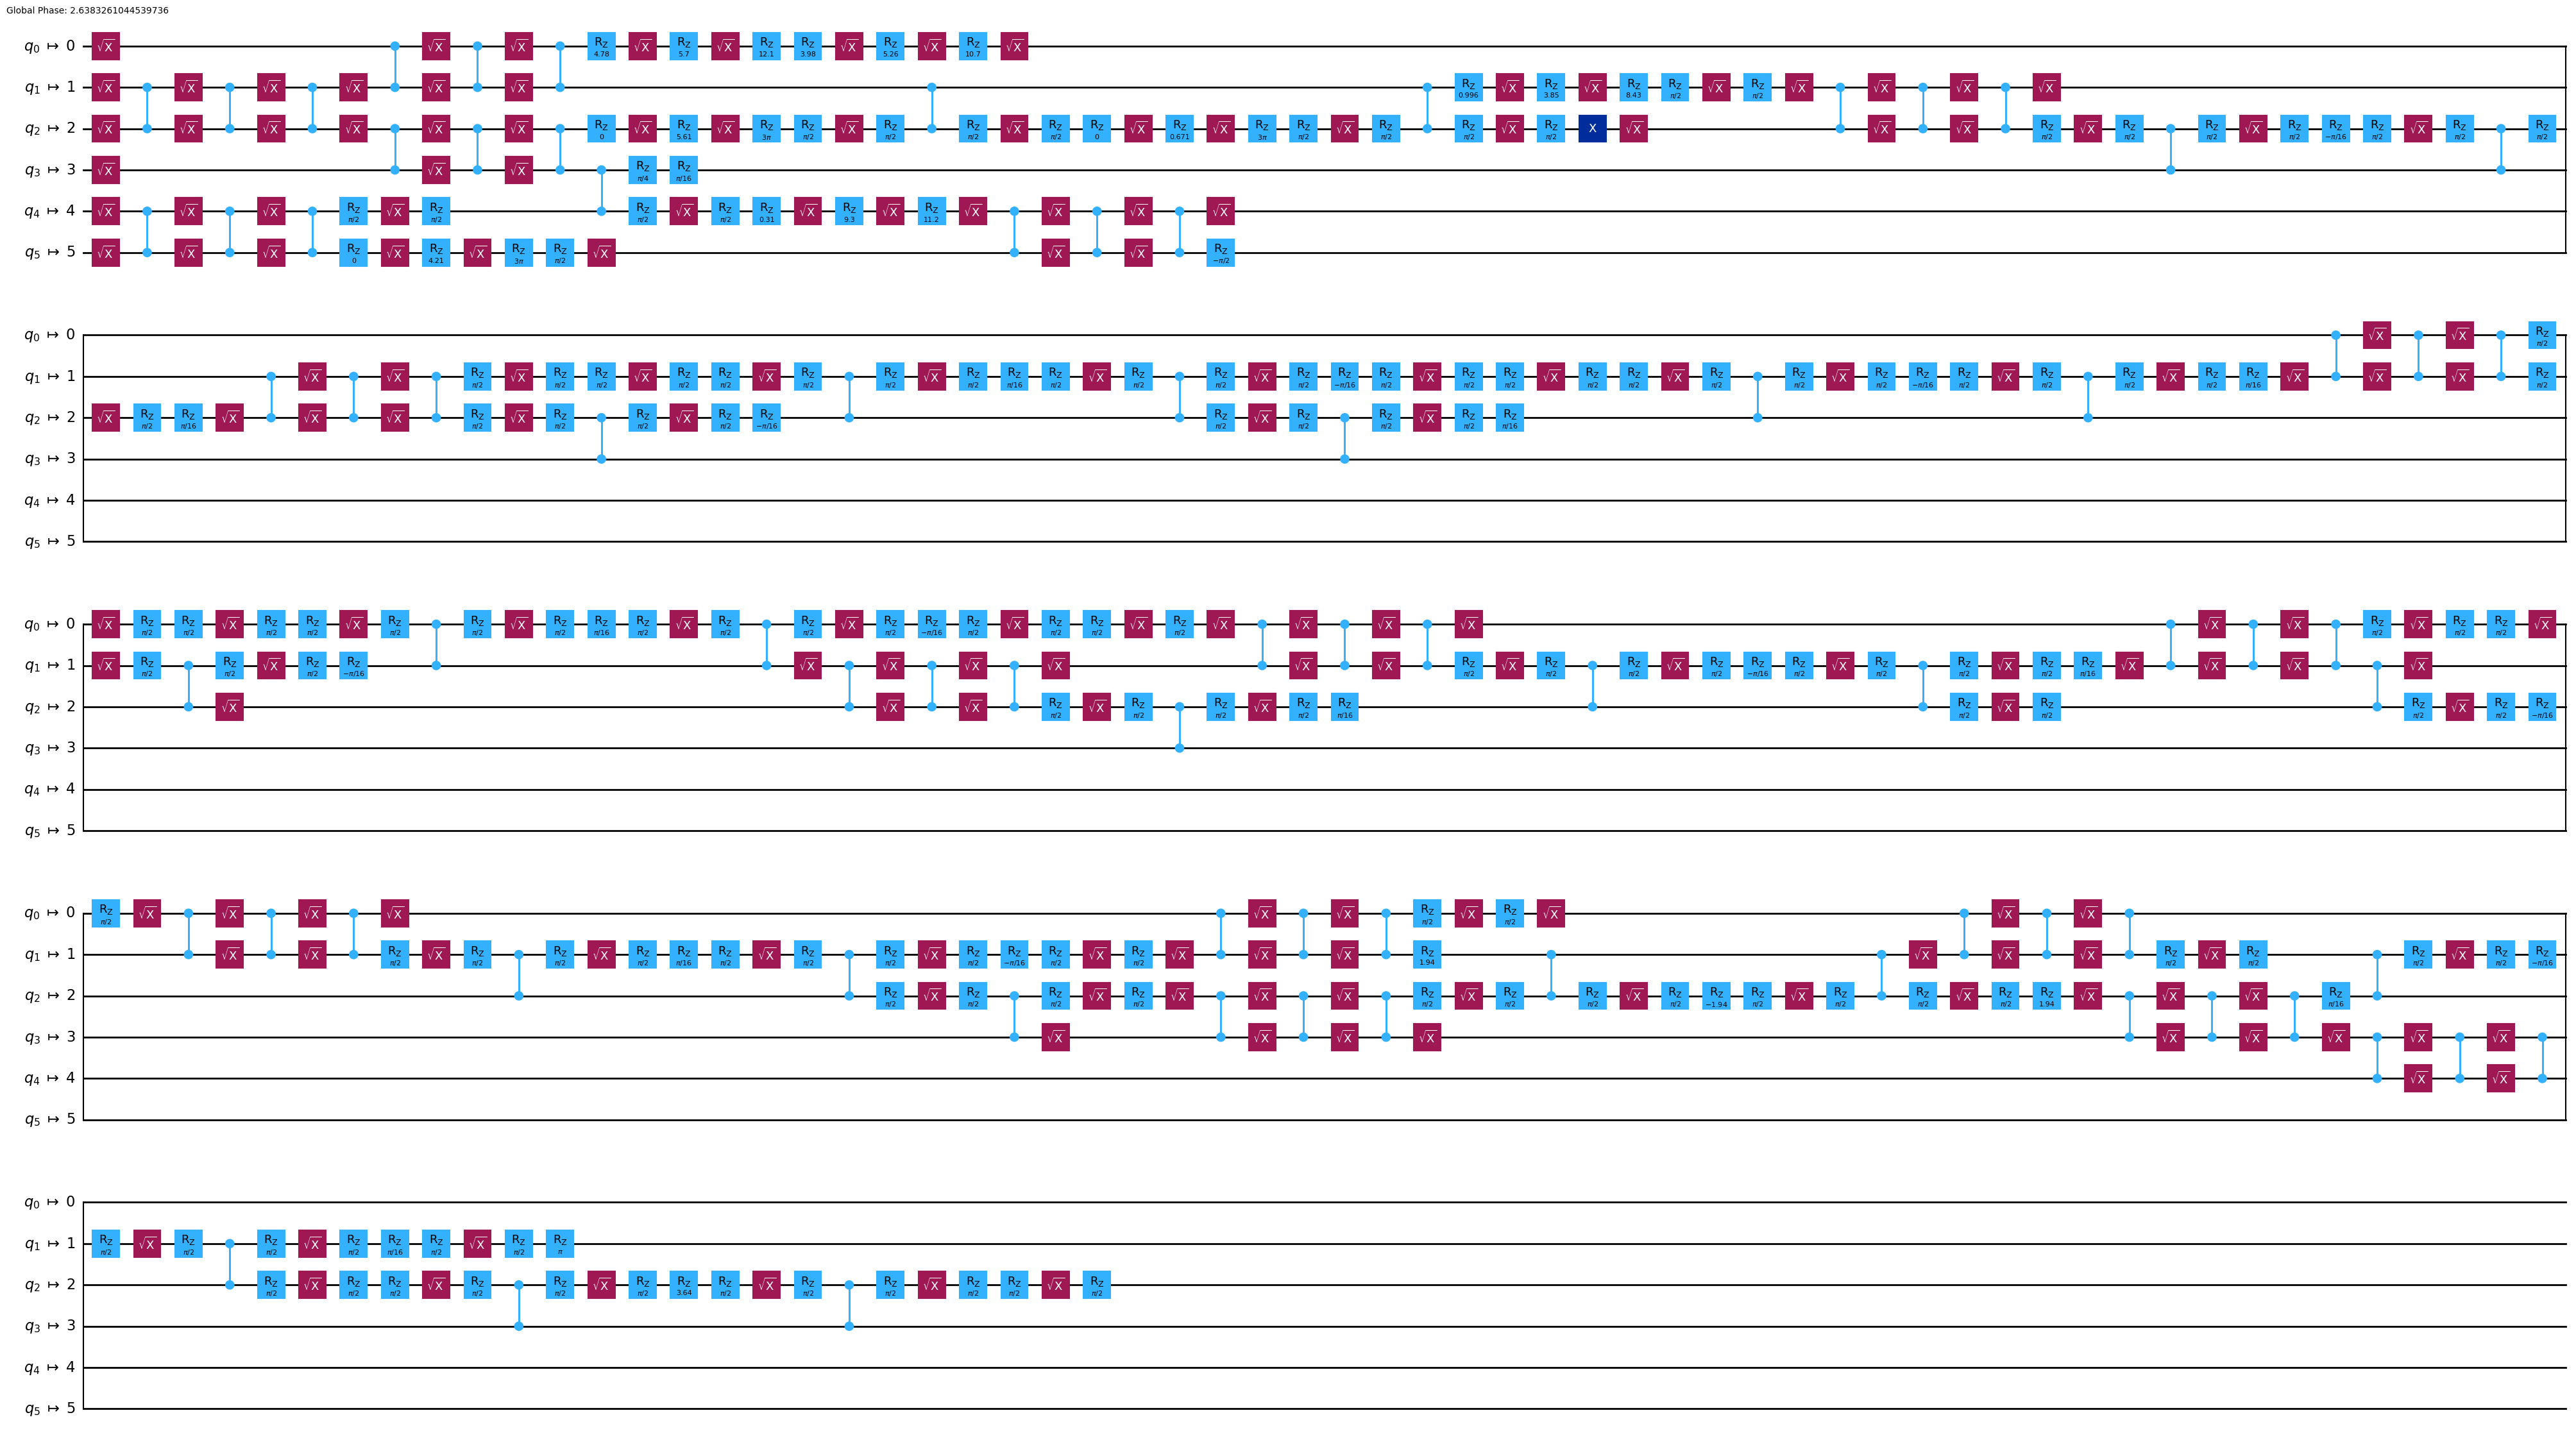

In [5]:
# Run for our random circuit
tr_lv0 = pm_level0.run(qc)

# uncomment the next line to draw circuit
tr_lv0.draw('mpl', idle_wires=False, fold=60)

In [6]:
# Find the circuit depth of the random circuit, the sum of the total gate number
# and compute the performance score of this circuit using scoring
circuit_depths['opt_lv_0'] = qc.depth()
gate_counts['opt_lv_0'] = sum(qc.count_ops().values())
scores['opt_lv_0'] = scoring(qc, backend)

print("Optimization level 0 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_0'])
print("Gate count:", gate_counts['opt_lv_0'])
print("Score:", scores['opt_lv_0'])

Optimization level 0 results
Circuit depth: 4
Gate count: 16
Score: 0.00016841754103991136


In [7]:
# Opt level 1- light optimization with a TrivialLayout
pm_level1 = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed)

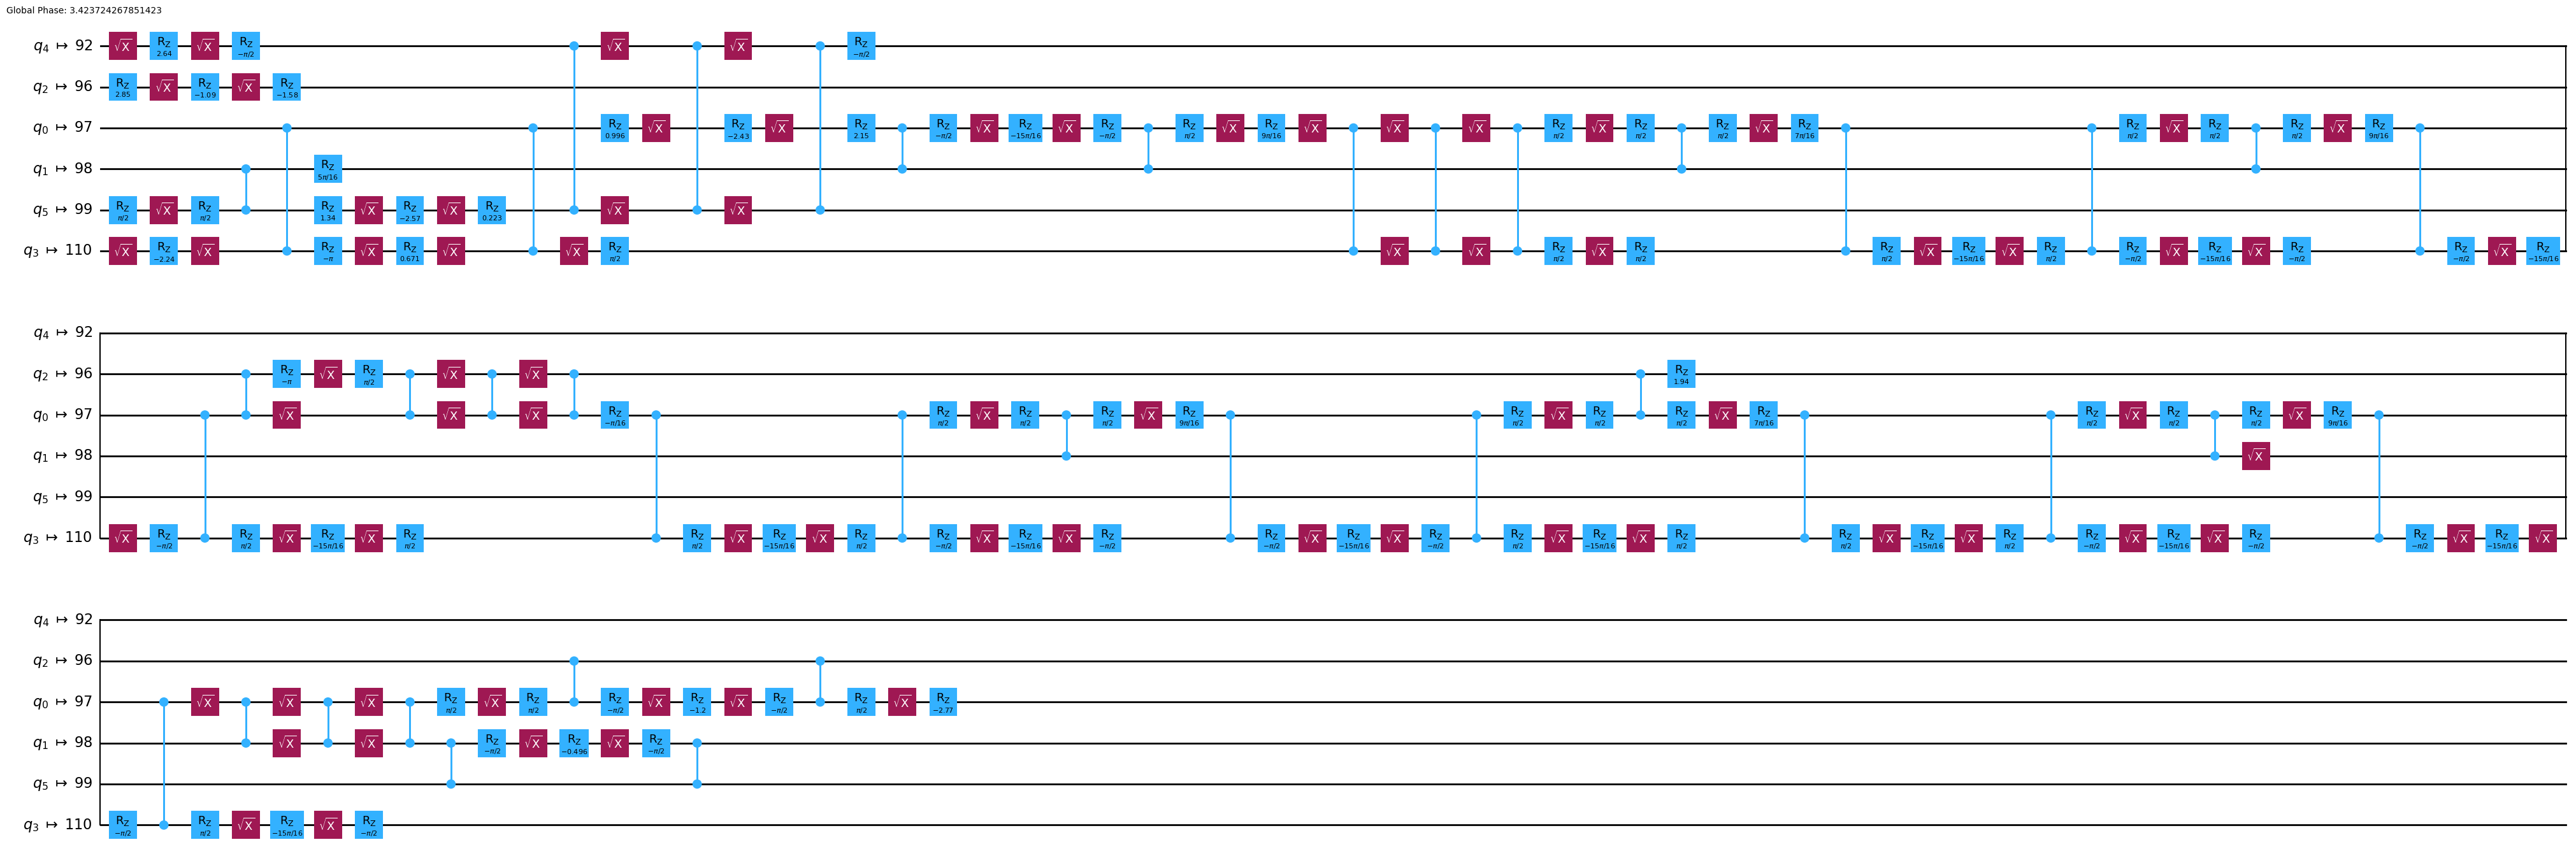

In [8]:
# Run for our random circuit
tr_lv1 = pm_level1.run(qc)

# uncomment the next line to draw circuit
tr_lv1.draw('mpl', idle_wires=False, fold=60)

In [9]:
circuit_depths['opt_lv_1'] = qc.depth()
gate_counts['opt_lv_1'] = sum(qc.count_ops().values())
scores['opt_lv_1'] = scoring(qc, backend)

print("Optimization level 1 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_1'])
print("Gate count:", gate_counts['opt_lv_1'])
print("Score:", scores['opt_lv_1'])

Optimization level 1 results
Circuit depth: 4
Gate count: 16
Score: 0.00016841754103991136


In [10]:
# Opt level 2- medium optimization, opt level 1 + heuristic optimized with greater search depth and trials of optimization function
pm_level2 = generate_preset_pass_manager(backend=backend, optimization_level=2, seed_transpiler=seed)

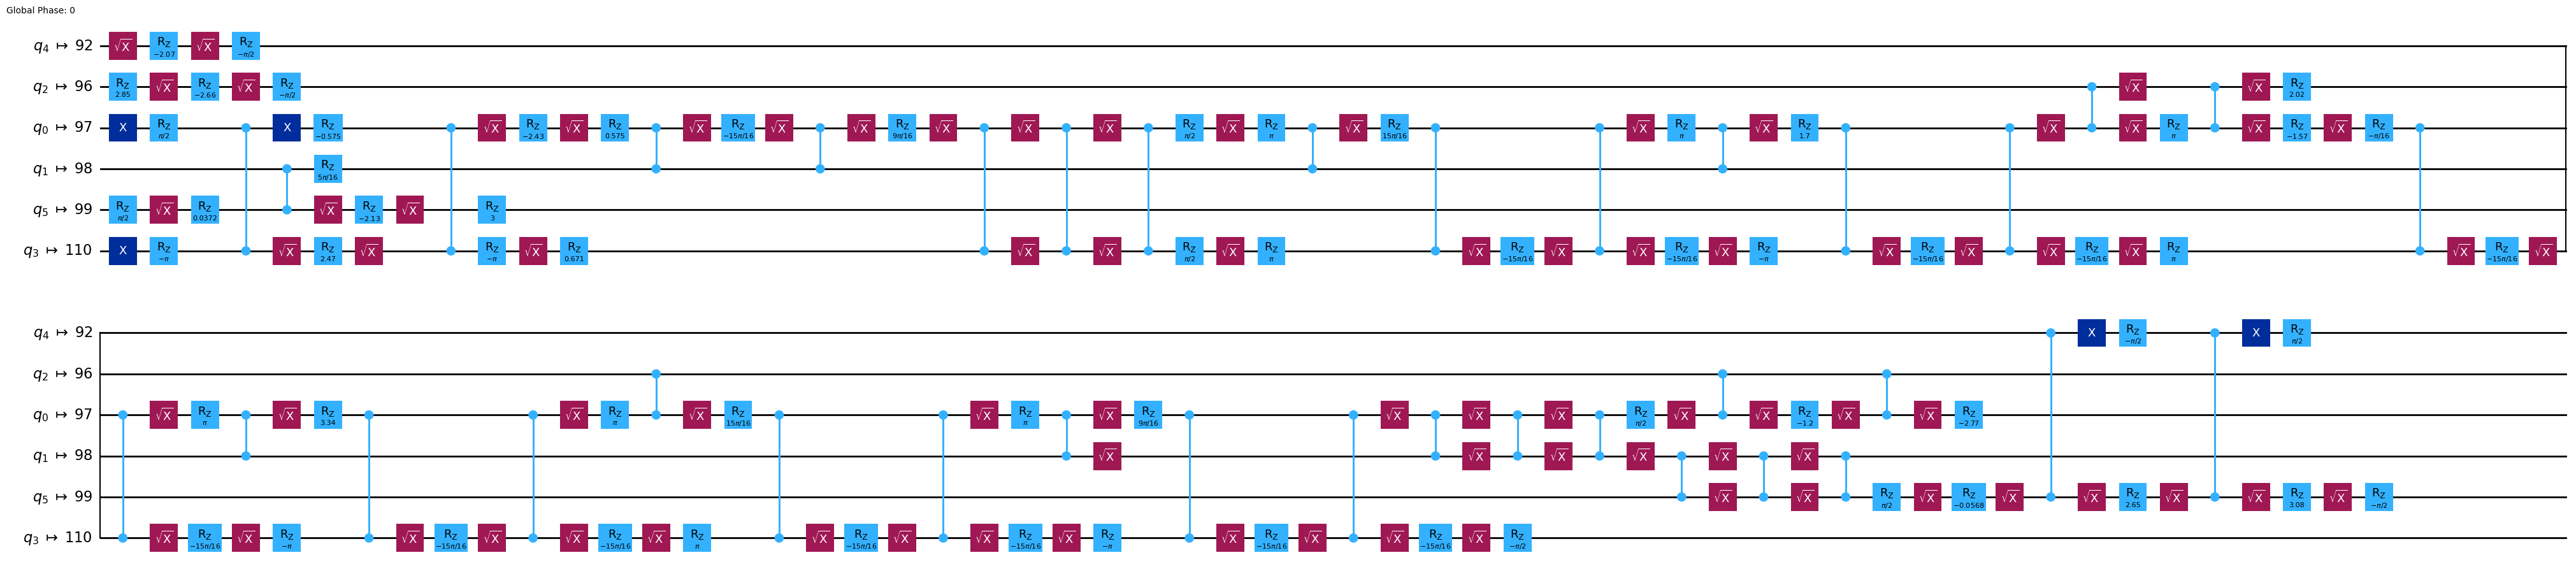

In [11]:
# Run for our random circuit
tr_lv2 = pm_level2.run(qc)

# uncomment the next line to draw circuit
tr_lv2.draw('mpl', idle_wires=False, fold=60)

In [12]:
circuit_depths['opt_lv_2'] = qc.depth()
gate_counts['opt_lv_2'] = sum(qc.count_ops().values())
scores['opt_lv_2'] = scoring(qc, backend)

print("Optimization level 2 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_2'])
print("Gate count:", gate_counts['opt_lv_2'])
print("Score:", scores['opt_lv_2'])

Optimization level 2 results
Circuit depth: 4
Gate count: 16
Score: 0.00016841754103991136


In [13]:
# Opt level 3- high optimization, opt level 2 + heuristic optimized on layout/routing further with greater effort/trials
pm_level3 = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed)

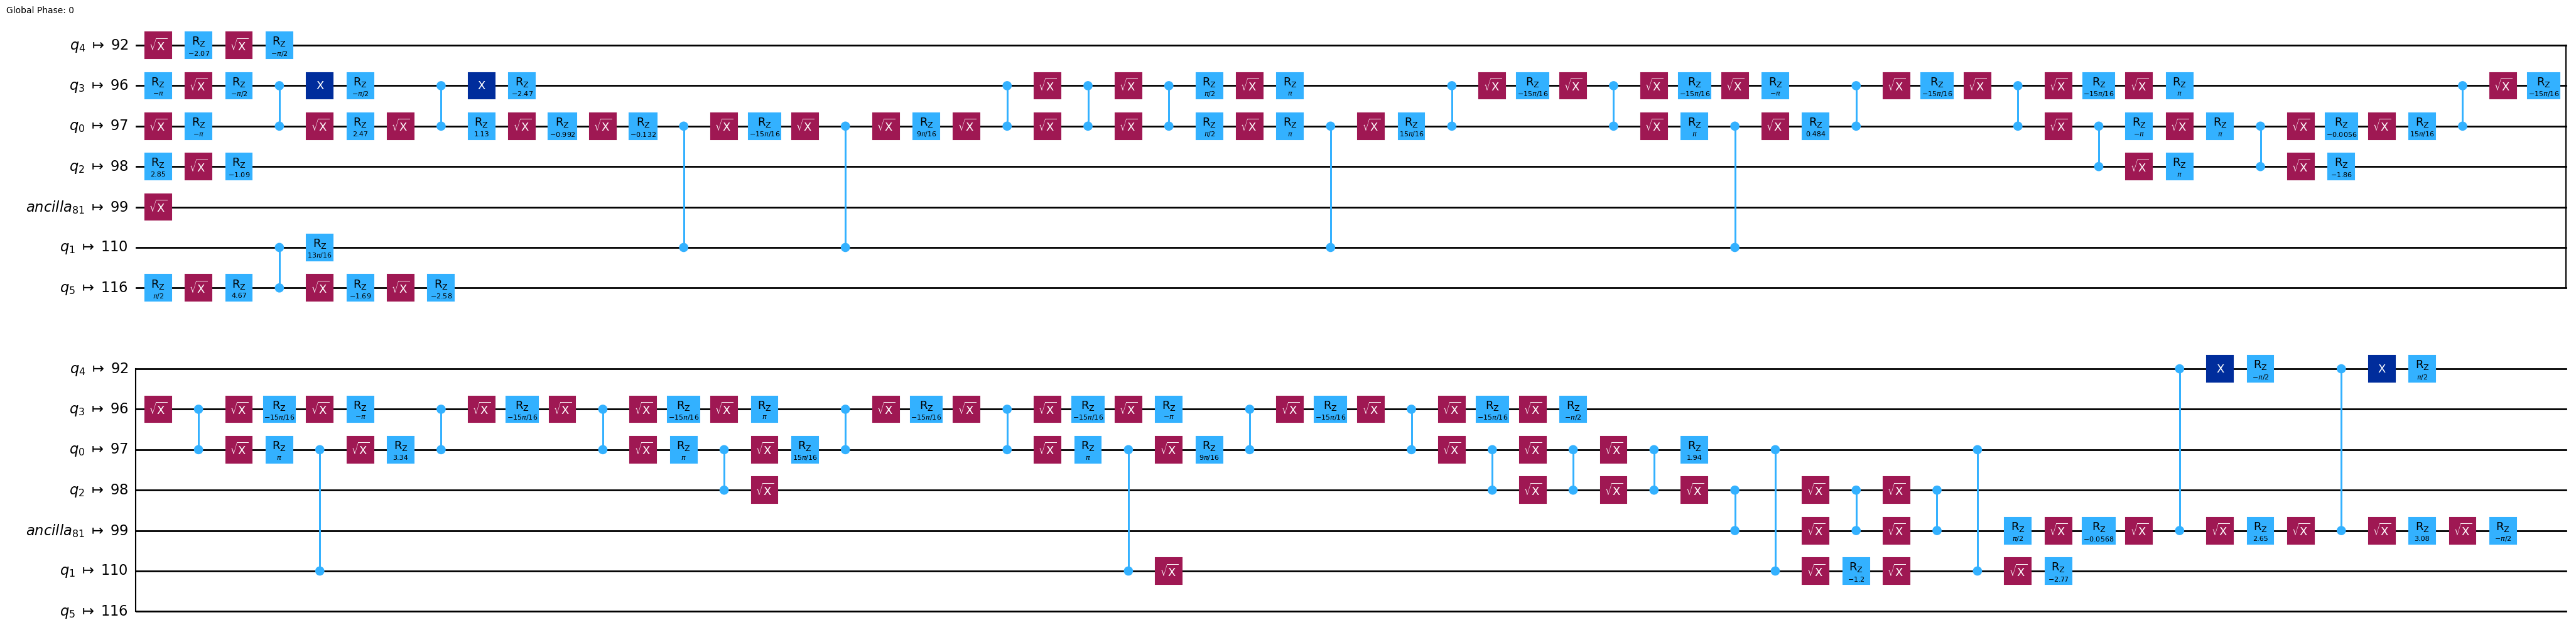

In [14]:
tr_lv3 = pm_level3.run(qc)
tr_lv3.draw('mpl', idle_wires=False, fold=60)

In [15]:
circuit_depths['opt_lv_3'] = qc.depth()
gate_counts['opt_lv_3'] = sum(qc.count_ops().values())
scores['opt_lv_3'] = scoring(qc, backend)

print("Optimization level 3 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_3'])
print("Gate count:", gate_counts['opt_lv_3'])
print("Score:", scores['opt_lv_3'])

Optimization level 3 results
Circuit depth: 4
Gate count: 16
Score: 0.00016841754103991136


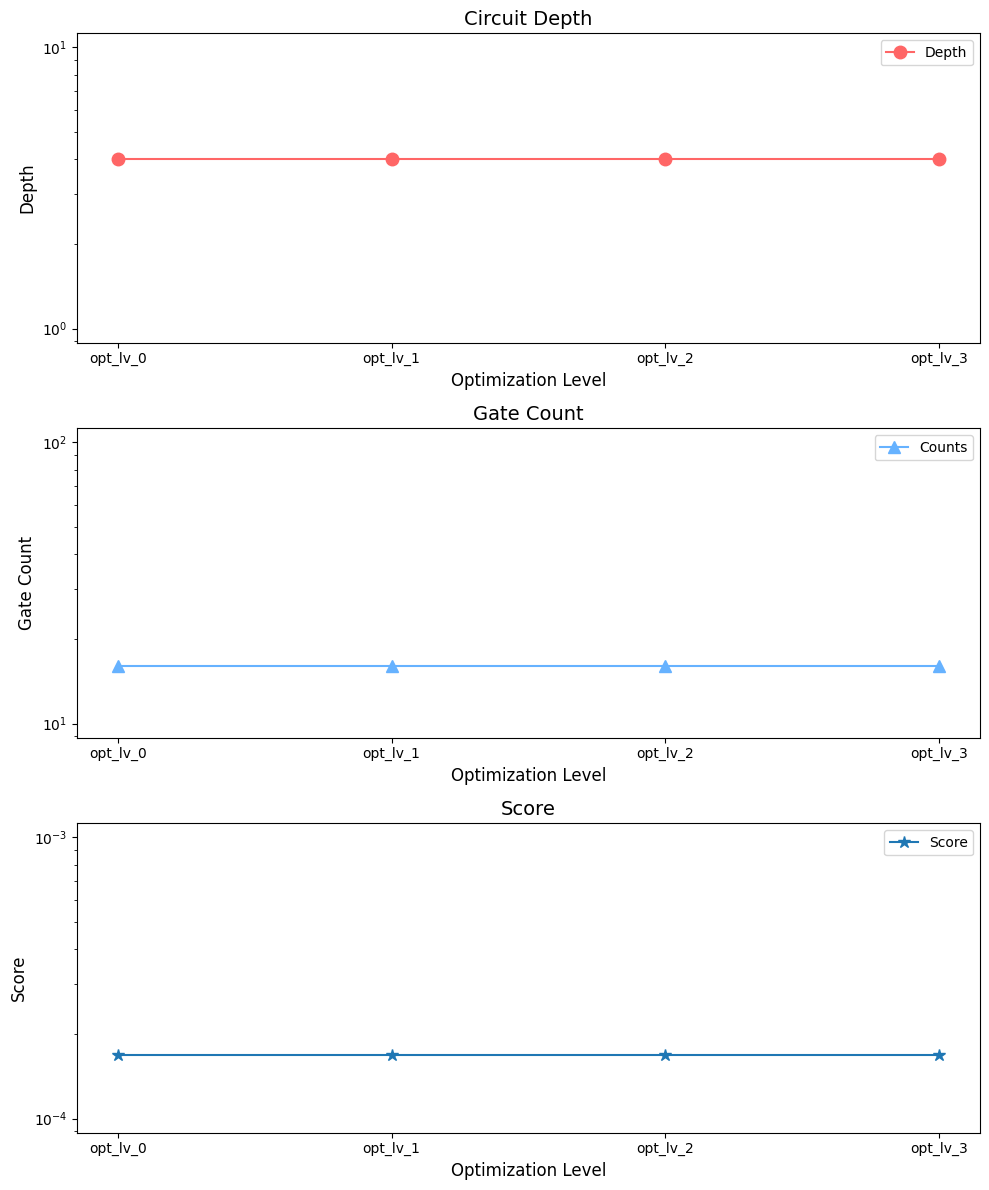

In [16]:
# Plot the comparisons of the 4 optimization levels
colors = ['#FF6666', '#66B2FF']
ax = ["opt_lv_0", "opt_lv_1", "opt_lv_2", "opt_lv_3"]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Circuit Depth
ax1.semilogy(ax, [circuit_depths[key] for key in ax],'o-',markersize=9, color='#FF6666', label="Depth")
ax1.set_xlabel("Optimization Level", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
ax2.semilogy(ax, [gate_counts[key] for key in ax],'^-',markersize=9, color='#66B2FF', label="Counts")
ax2.set_xlabel("Optimization Level", fontsize=12)
ax2.set_ylabel("Gate Count", fontsize=12)
ax2.set_title("Gate Count", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Score of Transpiled Circuit
ax3.semilogy(ax, [scores[key] for key in ax],'*-',markersize=9, label="Score")
ax3.set_xlabel("Optimization Level", fontsize=12)
ax3.set_ylabel("Score", fontsize=12)
ax3.set_title("Score", fontsize=14)
ax3.legend(fontsize=10)

fig.tight_layout()
plt.show()